# Python libraries

In [1]:
#pip install kmodes

In [37]:
#pip install kneed

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from kmodes.kprototypes import KPrototypes
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

# Loading the Data set 

In [2]:
data = pd.read_csv("weather_classification_data.csv")
data 

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14.0,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,39.0,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,30.0,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,38.0,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,27.0,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain,Rainy
...,...,...,...,...,...,...,...,...,...,...,...
13195,10.0,74,14.5,71.0,overcast,1003.15,1,Summer,1.0,mountain,Rainy
13196,-1.0,76,3.5,23.0,cloudy,1067.23,1,Winter,6.0,coastal,Snowy
13197,30.0,77,5.5,28.0,overcast,1012.69,3,Autumn,9.0,coastal,Cloudy
13198,3.0,76,10.0,94.0,overcast,984.27,0,Winter,2.0,inland,Snowy


## Data Cleaning 

In [3]:
data.isna().sum()

Temperature             0
Humidity                0
Wind Speed              0
Precipitation (%)       0
Cloud Cover             0
Atmospheric Pressure    0
UV Index                0
Season                  0
Visibility (km)         0
Location                0
Weather Type            0
dtype: int64

In [4]:
data.duplicated().sum()

0

In [5]:
data.rename(columns={
    'Precipitation (%)': 'Precipitation_percent',
    'Atmospheric Pressure': 'Atmospheric_Pressure',
    'Visibility (km)': 'Visibility_km',
    'Cloud Cover': 'Cloud_Cover',
    'Weather Type': 'Weather_Type',
    'Wind Speed': 'Wind_Speed',
    'UV Index': 'UV_Index'
    
}, inplace=True)

## Encoding 

In [6]:
data_en = pd.get_dummies(data,columns=['Cloud_Cover','Season','Location'],drop_first=True) 

In [7]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(data['Weather_Type'])
data_en['Weather_Type'] = le.transform(data_en['Weather_Type'])

In [8]:
for i, class_ in enumerate(le.classes_):
    print(f'{class_} is encoded as {i}')
    
inverse_transformed = list(le.inverse_transform([0, 1, 2, 3]))
print("Inverse Transformed:", inverse_transformed)

Cloudy is encoded as 0
Rainy is encoded as 1
Snowy is encoded as 2
Sunny is encoded as 3
Inverse Transformed: ['Cloudy', 'Rainy', 'Snowy', 'Sunny']


In [9]:
data_en

,Temperature,Humidity,Wind_Speed,Precipitation_percent,Atmospheric_Pressure,UV_Index,Visibility_km,Weather_Type,Cloud_Cover_cloudy,Cloud_Cover_overcast,Cloud_Cover_partly cloudy,Season_Spring,Season_Summer,Season_Winter,Location_inland,Location_mountain
0,14.0,73,9.5,82.0,1010.82,2,3.5,1,0,0,1,0,0,1,1,0
1,39.0,96,8.5,71.0,1011.43,7,10.0,0,0,0,1,1,0,0,1,0
2,30.0,64,7.0,16.0,1018.72,5,5.5,3,0,0,0,1,0,0,0,1
3,38.0,83,1.5,82.0,1026.25,7,1.0,3,0,0,0,1,0,0,0,0
4,27.0,74,17.0,66.0,990.67,1,2.5,1,0,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13195,10.0,74,14.5,71.0,1003.15,1,1.0,1,0,1,0,0,1,0,0,1
13196,-1.0,76,3.5,23.0,1067.23,1,6.0,2,1,0,0,0,0,1,0,0
13197,30.0,77,5.5,28.0,1012.69,3,9.0,0,0,1,0,0,0,0,0,0
13198,3.0,76,10.0,94.0,984.27,0,2.0,2,0,1,0,0,0,1,1,0


## Standardize the numerical features

In [10]:
numerical_columns = ['Temperature', 'Humidity', 'Wind_Speed','Precipitation_percent','UV_Index','Visibility_km','Atmospheric_Pressure']
categorical_columns = [col for col in data.columns if col not in numerical_columns]

In [11]:
categorical_columns

['Cloud_Cover', 'Season', 'Location', 'Weather_Type']

In [12]:
from sklearn.preprocessing import StandardScaler 

In [13]:
scaler = StandardScaler()

data_en_s = scaler.fit_transform(data_en[numerical_columns])

In [14]:
data_en_s

array([[-0.29493119,  0.21240351, -0.04808565, ..., -0.52010407,
        -0.58223095,  0.13420291],
       [ 1.14303484,  1.35138482, -0.19283608, ...,  0.77642368,
         1.34576796,  0.15060156],
       [ 0.62536707, -0.23328483, -0.40996172, ...,  0.25781258,
         0.01099948,  0.34657889],
       ...,
       [ 0.62536707,  0.41048722, -0.62708737, ..., -0.26079852,
         1.04915274,  0.18447418],
       [-0.92763624,  0.36096629,  0.02428956, ..., -1.03871517,
        -1.02715378, -0.5795417 ],
       [-1.38778537, -1.52082893, -1.42321472, ...,  0.25781258,
         1.34576796,  0.25652072]])

In [15]:
DS = pd.DataFrame(data_en_s, columns=numerical_columns, index=data_en.index)
onehotdf = data_en.drop(columns=numerical_columns)
DS = pd.concat([DS, onehotdf], axis=1)

In [16]:
DS

,Temperature,Humidity,Wind_Speed,Precipitation_percent,UV_Index,Visibility_km,Atmospheric_Pressure,Weather_Type,Cloud_Cover_cloudy,Cloud_Cover_overcast,Cloud_Cover_partly cloudy,Season_Spring,Season_Summer,Season_Winter,Location_inland,Location_mountain
0,-0.294931,0.212404,-0.048086,0.887629,-0.520104,-0.582231,0.134203,1,0,0,1,0,0,1,1,0
1,1.143035,1.351385,-0.192836,0.543291,0.776424,1.345768,0.150602,0,0,0,1,1,0,0,1,0
2,0.625367,-0.233285,-0.409962,-1.178401,0.257813,0.010999,0.346579,3,0,0,0,1,0,0,0,1
3,1.085516,0.707613,-1.206089,0.887629,0.776424,-1.323769,0.549008,3,0,0,0,1,0,0,0,0
4,0.452811,0.261924,1.037543,0.386773,-0.779410,-0.878846,-0.407490,1,0,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13195,-0.525006,0.261924,0.675666,0.543291,-0.779410,-1.323769,-0.071990,1,0,1,0,0,1,0,0,1
13196,-1.157711,0.360966,-0.916588,-0.959276,-0.779410,0.159307,1.650675,2,1,0,0,0,0,1,0,0
13197,0.625367,0.410487,-0.627087,-0.802759,-0.260799,1.049153,0.184474,0,0,1,0,0,0,0,0,0
13198,-0.927636,0.360966,0.024290,1.263271,-1.038715,-1.027154,-0.579542,2,0,1,0,0,0,1,1,0


# Splitting The Data set 

## With out standardizing

In [17]:
Y  = data_en['Weather_Type']
X = data_en.drop('Weather_Type',axis=1)

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=10)

In [19]:
X_train.head()

,Temperature,Humidity,Wind_Speed,Precipitation_percent,Atmospheric_Pressure,UV_Index,Visibility_km,Cloud_Cover_cloudy,Cloud_Cover_overcast,Cloud_Cover_partly cloudy,Season_Spring,Season_Summer,Season_Winter,Location_inland,Location_mountain
9645,32.0,64,6.0,86.0,1007.86,0,3.0,0,1,0,0,0,0,0,0
8002,34.0,79,12.0,95.0,1000.16,2,3.5,0,1,0,1,0,0,1,0
6329,-4.0,83,37.5,72.0,991.22,3,1.0,0,0,1,0,0,1,1,0
11103,17.0,66,19.5,71.0,1017.39,0,4.0,0,1,0,1,0,0,0,1
3600,-3.0,86,3.0,82.0,996.59,1,4.0,0,1,0,0,0,1,0,1


In [20]:
train_set = pd.concat([X_train,Y_train],axis=1)
train_set

,Temperature,Humidity,Wind_Speed,Precipitation_percent,Atmospheric_Pressure,UV_Index,Visibility_km,Cloud_Cover_cloudy,Cloud_Cover_overcast,Cloud_Cover_partly cloudy,Season_Spring,Season_Summer,Season_Winter,Location_inland,Location_mountain,Weather_Type
9645,32.0,64,6.0,86.0,1007.86,0,3.0,0,1,0,0,0,0,0,0,1
8002,34.0,79,12.0,95.0,1000.16,2,3.5,0,1,0,1,0,0,1,0,1
6329,-4.0,83,37.5,72.0,991.22,3,1.0,0,0,1,0,0,1,1,0,2
11103,17.0,66,19.5,71.0,1017.39,0,4.0,0,1,0,1,0,0,0,1,1
3600,-3.0,86,3.0,82.0,996.59,1,4.0,0,1,0,0,0,1,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11633,3.0,68,2.5,93.0,983.14,1,1.0,0,1,0,0,0,1,1,0,2
1344,24.0,98,11.5,63.0,1017.39,2,1.5,0,0,1,0,0,0,1,0,1
12815,24.0,73,7.5,82.0,1015.08,3,4.0,0,1,0,0,0,0,1,0,1
7293,19.0,33,14.0,18.0,1091.81,6,10.5,1,0,0,0,0,1,0,1,0


In [21]:
test_set = pd.concat([X_test,Y_test],axis=1)
test_set

,Temperature,Humidity,Wind_Speed,Precipitation_percent,Atmospheric_Pressure,UV_Index,Visibility_km,Cloud_Cover_cloudy,Cloud_Cover_overcast,Cloud_Cover_partly cloudy,Season_Spring,Season_Summer,Season_Winter,Location_inland,Location_mountain,Weather_Type
11923,13.0,75,9.0,58.0,1000.52,1,3.0,0,0,1,0,1,0,1,0,1
2331,3.0,73,9.5,59.0,983.56,0,2.5,0,1,0,0,0,1,1,0,2
217,18.0,74,0.5,39.0,1007.53,1,8.5,0,1,0,0,0,0,0,1,0
1760,38.0,88,19.5,85.0,1009.03,0,4.5,0,0,1,1,0,0,1,0,0
3963,24.0,38,4.5,15.0,1029.37,9,7.0,0,0,1,1,0,0,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9950,-5.0,97,10.0,78.0,980.14,1,1.5,0,1,0,0,0,1,1,0,2
4515,24.0,56,8.5,48.0,1012.30,4,7.0,0,1,0,0,0,0,0,0,0
1996,12.0,89,6.5,86.0,992.27,2,1.5,0,1,0,0,1,0,0,0,1
1457,28.0,62,6.5,69.0,994.82,1,3.0,0,1,0,0,0,1,0,1,1


## With standardize

In [25]:
Ys  = DS['Weather_Type']
Xs = DS.drop('Weather_Type',axis=1)

In [26]:
Xs_train, Xs_test, Ys_train, Ys_test = train_test_split(Xs, Ys, test_size=0.2, random_state=10)

In [27]:
train_set_s = pd.concat([Xs_train,Ys_train],axis=1)
train_set_s

,Temperature,Humidity,Wind_Speed,Precipitation_percent,UV_Index,Visibility_km,Atmospheric_Pressure,Cloud_Cover_cloudy,Cloud_Cover_overcast,Cloud_Cover_partly cloudy,Season_Spring,Season_Summer,Season_Winter,Location_inland,Location_mountain,Weather_Type
9645,0.740404,-0.233285,-0.554712,1.012843,-1.038715,-0.730539,0.054629,0,1,0,0,0,0,0,0,1
8002,0.855442,0.509529,0.313790,1.294574,-0.520104,-0.582231,-0.152370,0,1,0,1,0,0,1,0,1
6329,-1.330267,0.707613,4.004926,0.574594,-0.260799,-1.323769,-0.392705,0,0,1,0,0,1,1,0,2
11103,-0.122375,-0.134243,1.399419,0.543291,-1.038715,-0.433923,0.310824,0,1,0,1,0,0,0,1,1
3600,-1.272748,0.856176,-0.988963,0.887629,-0.779410,-0.433923,-0.248343,0,1,0,0,0,1,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11633,-0.927636,-0.035201,-1.061339,1.231967,-0.779410,-1.323769,-0.609920,0,1,0,0,0,1,1,0,2
1344,0.280255,1.450427,0.241415,0.292863,-0.520104,-1.175461,0.310824,0,0,1,0,0,0,1,0,1
12815,0.280255,0.212404,-0.337587,0.887629,-0.260799,-0.433923,0.248725,0,1,0,0,0,0,1,0,1
7293,-0.007338,-1.768434,0.603291,-1.115794,0.517118,1.494076,2.311460,1,0,0,0,0,1,0,1,0


In [27]:
test_set_s = pd.concat([Xs_test,Ys_test],axis=1)
test_set_s

,Temperature,Humidity,Wind_Speed,Precipitation_percent,UV_Index,Visibility_km,Atmospheric_Pressure,Cloud_Cover_cloudy,Cloud_Cover_overcast,Cloud_Cover_partly cloudy,Season_Spring,Season_Summer,Season_Winter,Location_inland,Location_mountain,Weather_Type
11923,-0.352450,0.311445,-0.120461,0.136346,-0.779410,-0.730539,-0.142692,0,0,1,0,1,0,1,0,1
2331,-0.927636,0.212404,-0.048086,0.167649,-1.038715,-0.878846,-0.598629,0,1,0,0,0,1,1,0,2
217,-0.064857,0.261924,-1.350840,-0.458420,-0.779410,0.900845,0.045758,0,1,0,0,0,0,0,1,0
1760,1.085516,0.955217,1.399419,0.981540,-1.038715,-0.285616,0.086082,0,0,1,1,0,0,1,0,0
3963,0.280255,-1.520829,-0.771838,-1.209704,1.295035,0.455922,0.632883,0,0,1,1,0,0,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9950,-1.387785,1.400906,0.024290,0.762415,-0.779410,-1.175461,-0.690569,0,1,0,0,0,1,1,0,2
4515,0.280255,-0.629452,-0.192836,-0.176689,-0.001493,0.455922,0.173990,0,1,0,0,0,0,0,0,0
1996,-0.409968,1.004738,-0.482337,1.012843,-0.520104,-1.175461,-0.364477,0,1,0,0,1,0,0,0,1
1457,0.510330,-0.332327,-0.482337,0.480684,-0.779410,-0.730539,-0.295926,0,1,0,0,0,1,0,1,1


## K-Prototype Clustring 

In [28]:
YC  = data['Weather_Type']
XC = data.drop('Weather_Type',axis=1)

In [29]:
XC_train, XC_test, YC_train, YC_test = train_test_split(XC, YC, test_size=0.2, random_state=10)

In [30]:
train_set_C = pd.concat([XC_train,YC_train],axis=1)
test_set_C = pd.concat([XC_test,YC_test],axis=1)

In [31]:
categorical_columns = [col for col in data.columns if col not in numerical_columns and col != 'Weather_Type']
print("Categorical columns:", categorical_columns)

Categorical columns: ['Cloud_Cover', 'Season', 'Location']


In [32]:
categorical_indices = [XC_train.columns.get_loc(col) for col in categorical_columns if col in XC_train.columns]
print("Categorical column indices:", categorical_indices)

Categorical column indices: [4, 7, 9]


In [34]:
df_mat = XC_train.to_numpy()

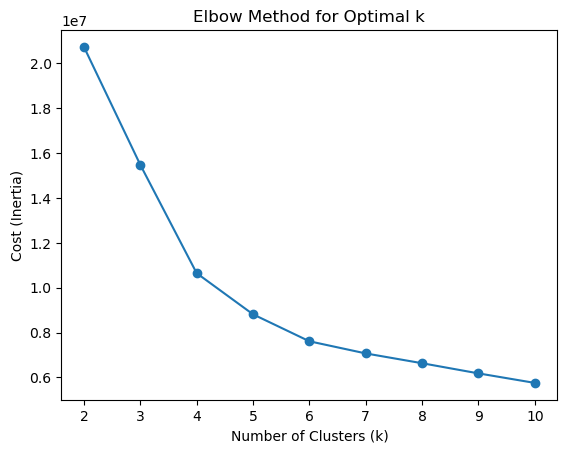

In [35]:
from kmodes.kprototypes import KPrototypes

# Specify the indices of the categorical features
categorical_indices = [4,7,9]
costs = []

for k in range(2,11):
    kproto = KPrototypes(n_clusters=k, init='Cao', verbose=0)
    clusters = kproto.fit_predict(df_mat, categorical=categorical_indices)
    cost = kproto.cost_
    costs.append(cost)

# Plot the elbow graph
plt.plot(range(2,11), costs, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cost (Inertia)')
plt.show()

In [38]:
from kneed import KneeLocator
cost_knee_c3 = KneeLocator(
        x=range(2,11), 
        y=costs, 
        S=0., curve="convex", direction="decreasing", online=True)

K_cost_c3 = cost_knee_c3.elbow   
print("elbow at k =", f'{K_cost_c3:.0f} clusters')

elbow at k = 4 clusters


In [50]:
kproto = KPrototypes(n_clusters=4, init='Cao', verbose=0)
clusters = kproto.fit_predict(df_mat, categorical=categorical_indices)

In [51]:
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score, silhouette_samples

# Separate numerical and categorical data
num_data = XC_train.select_dtypes(['float']).values
cat_data = XC_train.select_dtypes(['int']).values
cat_data = cat_data.astype('float')

In [63]:
# Calculate Euclidean distance for numerical data
euclidean_dist = cdist(num_data, num_data, metric='euclidean')

# Calculate matching distance for categorical data
matching_dist = cdist(cat_data, cat_data, metric='matching')

# Combine distances with weights
# Assuming equal weights for numerical and categorical distances
weight_num = 0.1
weight_cat = 15

combined_dist = weight_num * euclidean_dist + weight_cat * matching_dist

# getting the sillout score
s = silhouette_score(combined_dist, clusters, metric="precomputed")
print('silhouette score (k=4):', s)

silhouette score (k=4): 0.19947980801942305


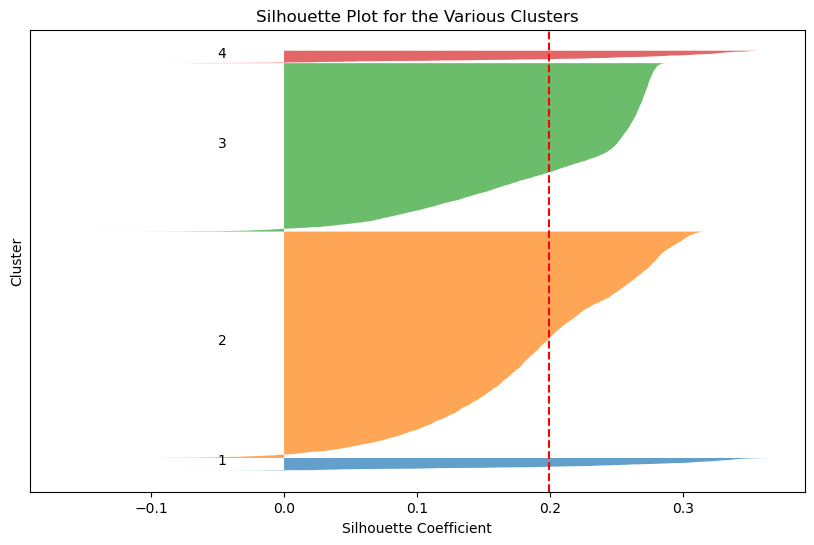

In [64]:
# Compute silhouette scores for each sample
silhouette_vals = silhouette_samples(combined_dist, clusters, metric="precomputed")

# Plot silhouette scores
fig, ax = plt.subplots(figsize=(10, 6))

y_lower, y_upper = 0, 0
for i in range(4):
    cluster_silhouette_vals = silhouette_vals[clusters == i]
    cluster_silhouette_vals.sort()

    y_upper += len(cluster_silhouette_vals)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals, alpha=0.7)
    ax.text(-0.05, y_lower + 0.5 * len(cluster_silhouette_vals), str(i + 1))

    y_lower = y_upper

ax.axvline(x=s, color="red", linestyle="--")
ax.set_xlabel('Silhouette Coefficient')
ax.set_ylabel('Cluster')
ax.set_title('Silhouette Plot for the Various Clusters')
ax.set_yticks([])  # Clear the y-axis labels

plt.show()

# Multiple logistic regression

In [36]:
from sklearn.linear_model import LogisticRegression
logi_model = LogisticRegression(random_state = 10,multi_class='multinomial')

In [37]:
param_grid_logi = {'solver': ['lbfgs', 'newton-cg','sag','saga']}  ###,'penalty':['None','l2']

In [38]:
grid_search_logi = GridSearchCV(estimator=logi_model, param_grid=param_grid_logi, cv=5, scoring='accuracy')

In [39]:
grid_search_logi.fit(Xs_train ,Ys_train)

E:\applications\Anaconda\files\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
E:\applications\Anaconda\files\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

GridSearchCV(cv=5,
             estimator=LogisticRegression(multi_class='multinomial',
                                          random_state=10),
             param_grid={'solver': ['lbfgs', 'newton-cg', 'sag', 'saga']},
             scoring='accuracy')

In [40]:
best_params_logi = grid_search_logi.best_params_
best_params_logi

{'solver': 'lbfgs'}

In [41]:
best_logi_model = grid_search_logi.best_estimator_
best_logi_model

LogisticRegression(multi_class='multinomial', random_state=10)

In [42]:
y_pred_logi = best_logi_model.predict(Xs_test)

In [43]:
Accuracy_logi= accuracy_score(Ys_test, y_pred_logi)
Accuracy_logi

0.871969696969697

In [44]:
y_train_pred_logi = best_logi_model.predict(Xs_train)
Accuracy_train_logi = accuracy_score(Ys_train, y_train_pred_logi)
print("Training Set Accuracy:", Accuracy_train_logi)

Training Set Accuracy: 0.8705492424242425


In [45]:
#print(classification_report(Ys_test,y_pred_logi))

In [46]:
f1_score(Ys_test,y_pred_logi, average='macro')

0.8717694364563963

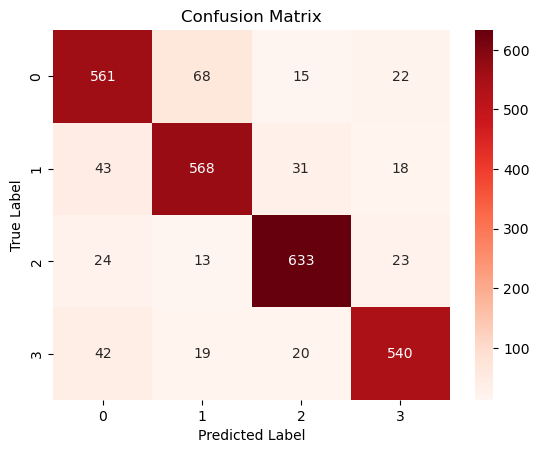

In [47]:
class_labels = ['0', '1', '2', '3']
conf_matrix_logi = confusion_matrix(Ys_test, y_pred_logi)
sns.heatmap(conf_matrix_logi, annot=True, fmt='d', cmap='Reds', 
            xticklabels=class_labels, 
            yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# XG-Boost 

In [48]:
import xgboost as xgb
xgb_model = xgb.XGBClassifier(objective='multi:softprob',random_state=10,booster='dart',alpha=5,gamma=1,sample_type='uniform',normalize_type='forest',rate_drop=0.1)

In [49]:
param_grid_xgb = {'learning_rate': [0.05, 0.1] ,'max_depth': [2, 3],'n_estimators': [50, 100],'lambda':[2.5,3],'subsample': [0.7, 0.8],'colsample_bytree': [0.7, 0.8]}

In [50]:
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=5, scoring='neg_log_loss',n_jobs=-1)

In [51]:
#grid_search_xgb.fit(X_train ,Y_train,eval_set=[(X_test,Y_test)],early_stopping_rounds=20, eval_metric="mlogloss",verbose=True)

In [52]:
grid_search_xgb.fit(X_train ,Y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(alpha=3, base_score=None, booster='dart',
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=3, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     normalize_type='forest',
                                     num_parallel_tree=None,
                                     objective='multi:softprob', predictor=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.8], 'lambda': [2.5, 3],
                         'learning_rate': [0.05, 0.1], 'max_depth': [2, 3],
                         'n_estimators': [50, 100], 'subsample': [0.7, 0.8]},
             scoring='neg_log_loss')

In [53]:
best_params_xgb = grid_search_xgb.best_params_
best_params_xgb

{'colsample_bytree': 0.8,
 'lambda': 3,
 'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 100,
 'subsample': 0.8}

In [54]:
best_xgb_model = grid_search_xgb.best_estimator_
best_xgb_model

XGBClassifier(alpha=3, base_score=0.5, booster='dart', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=3, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='', lambda=3,
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, normalize_type='forest', num_parallel_tree=1,
              objective='multi:softprob', ...)

In [55]:
y_pred_xgb = best_xgb_model.predict(X_test)

In [56]:
Accuracy_xgb = accuracy_score(Y_test, y_pred_xgb)
Accuracy_xgb

0.9090909090909091

In [57]:
y_train_pred_xgb = best_xgb_model.predict(X_train)
Accuracy_train_xgb = accuracy_score(Y_train, y_train_pred_xgb)
print("Training Set Accuracy:", Accuracy_train_xgb)

Training Set Accuracy: 0.9232954545454546


In [58]:
#print(classification_report(Y_test,y_pred_xgb))
f1_score(Y_test,y_pred_xgb, average='macro')

0.9089046097268636

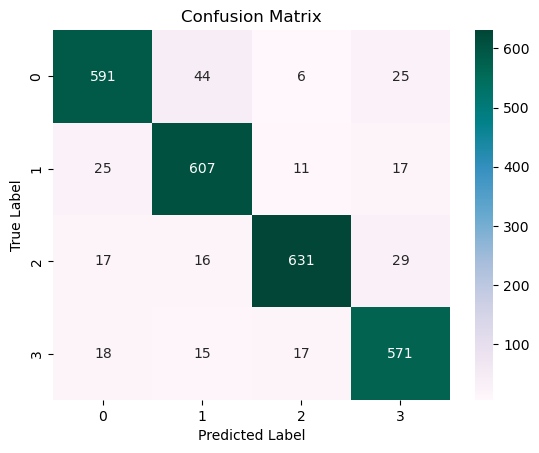

In [59]:
class_labels = ['0', '1', '2', '3']
conf_matrix_logi = confusion_matrix(Y_test, y_pred_xgb)
sns.heatmap(conf_matrix_logi, annot=True, fmt='d', cmap='PuBuGn', 
            xticklabels=class_labels, 
            yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Random Forest 

In [60]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=10)

In [61]:
param_grid_rf = {'criterion': ['gini','entropy'] ,'n_estimators': [25,35,45],'max_depth': [2,3,4]} 

In [62]:
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, scoring='accuracy')

In [63]:
grid_search_rf.fit(X_train ,Y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=10),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4], 'n_estimators': [25, 35, 45]},
             scoring='accuracy')

In [64]:
best_params_rf = grid_search_rf.best_params_
best_params_rf

{'criterion': 'gini', 'max_depth': 4, 'n_estimators': 45}

In [65]:
best_rf_model = grid_search_rf.best_estimator_
best_rf_model

RandomForestClassifier(max_depth=4, n_estimators=45, random_state=10)

In [66]:
y_pred_rf = best_rf_model.predict(X_test)

In [67]:
Accuracy_rf = accuracy_score(Y_test, y_pred_rf)
Accuracy_rf

0.8950757575757575

In [68]:
y_train_pred_rf = best_rf_model.predict(X_train)
Accuracy_train_rf = accuracy_score(Y_train, y_train_pred_rf)
print("Training Set Accuracy:", Accuracy_train_rf)

Training Set Accuracy: 0.9047348484848485


In [69]:
#print(classification_report(Y_test,y_pred_rf))
f1_score(Y_test,y_pred_rf, average='macro')

0.8951840774505464

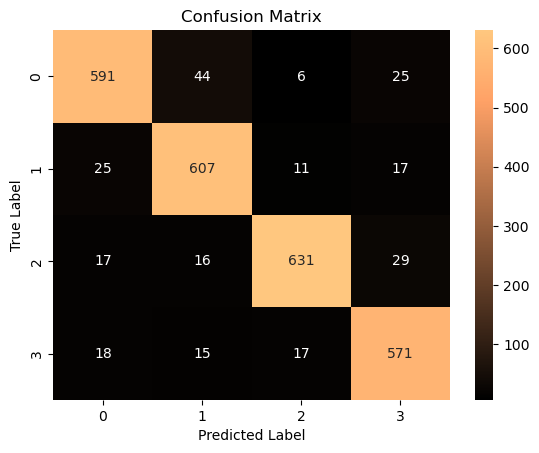

In [70]:
class_labels = ['0', '1', '2', '3']
conf_matrix_rf = confusion_matrix(Y_test, y_pred_rf)
sns.heatmap(conf_matrix_logi, annot=True, fmt='d', cmap='copper', 
            xticklabels=class_labels, 
            yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Gradient Boosting

In [71]:
from sklearn.ensemble import GradientBoostingClassifier
gbm_model = GradientBoostingClassifier(random_state=10)

In [72]:
param_grid_gbm = {'learning_rate': [0.01, 0.1, 0.2] ,'max_depth': [2,3,4],'n_estimators': [20,25,30]}

In [73]:
grid_search_gbm = GridSearchCV(estimator=gbm_model, param_grid=param_grid_gbm, cv=3, scoring='accuracy',n_jobs = -1, verbose = 1)

In [74]:
grid_search_gbm.fit(X_train,Y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=10),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [2, 3, 4], 'n_estimators': [20, 25, 30]},
             scoring='accuracy', verbose=1)

In [75]:
best_params_gbm = grid_search_gbm.best_params_
best_params_gbm

{'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 30}

In [76]:
best_gbm_model = grid_search_gbm.best_estimator_
best_gbm_model

GradientBoostingClassifier(learning_rate=0.2, max_depth=4, n_estimators=30,
                           random_state=10)

In [77]:
y_pred_gbm = best_gbm_model.predict(X_test)

In [78]:
Accuracy_gbm = accuracy_score(Y_test, y_pred_rf)
Accuracy_gbm

0.8950757575757575

In [79]:
y_train_pred_gbm = best_gbm_model.predict(X_train)
Accuracy_train_gbm = accuracy_score(Y_train, y_train_pred_gbm)
print("Training Set Accuracy:", Accuracy_train_gbm)

Training Set Accuracy: 0.9637310606060606


In [80]:
f1_score(Y_test,y_pred_gbm, average='macro')

0.9090519543229617

# ADA Boosting

In [81]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [82]:
base_estimator = DecisionTreeClassifier()

param_grid = {
    'base_estimator__max_depth': [1, 2, 3, 4, 5], 
    'n_estimators': [50, 100, 200],  
    'learning_rate': [0.01, 0.1, 1],  
}

In [83]:
ada_model = AdaBoostClassifier(base_estimator=base_estimator, random_state=10,algorithm='SAMME.R')

In [84]:
grid_search_ada = GridSearchCV(estimator=ada_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

In [85]:
grid_search_ada.fit(X_train, Y_train)

E:\applications\Anaconda\files\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),
                                          random_state=10),
             n_jobs=-1,
             param_grid={'base_estimator__max_depth': [1, 2, 3, 4, 5],
                         'learning_rate': [0.01, 0.1, 1],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [86]:
best_params_ada = grid_search_ada.best_params_
print(f"Best Parameters: {best_params_ada}")

Best Parameters: {'base_estimator__max_depth': 4, 'learning_rate': 0.1, 'n_estimators': 50}


In [87]:
best_ada_model = grid_search_ada.best_estimator_
best_ada_model

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=4),
                   learning_rate=0.1, random_state=10)

In [88]:
y_pred_ada = best_ada_model.predict(X_test)

In [89]:
Accuracy_ada = accuracy_score(Y_test, y_pred_ada)
Accuracy_ada

0.9068181818181819

In [90]:
f1_score(Y_test,y_pred_ada, average='macro')

0.9068016512176904

In [91]:
y_train_pred_ada = best_ada_model.predict(X_train)
Accuracy_train_ada = accuracy_score(Y_train, y_train_pred_ada)
print("Training Set Accuracy:", Accuracy_train_ada)

Training Set Accuracy: 0.959659090909091


# SVM 

In [100]:
from sklearn.svm import LinearSVC
svm_linearK_model = LinearSVC(penalty='l2',multi_class='ovr',random_state=10,loss='hinge')

In [101]:
param_grid_svm_linearK = {'C': [2,2.5,3]} 

In [102]:
grid_search_svm_linearK = GridSearchCV(estimator=svm_linearK_model, param_grid=param_grid_svm_linearK, scoring='accuracy', cv=5, n_jobs=-1)

In [103]:
grid_search_svm_linearK.fit(Xs_train,Ys_train)

E:\applications\Anaconda\files\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


GridSearchCV(cv=5, estimator=LinearSVC(loss='hinge', random_state=10),
             n_jobs=-1, param_grid={'C': [2, 2.5, 3]}, scoring='accuracy')

In [104]:
best_svm_linearK_params = grid_search_svm_linearK.best_params_
best_svm_linearK_params

{'C': 2.5}

In [105]:
best_svm_linearK_model = grid_search_svm_linearK.best_estimator_
best_svm_linearK_model

LinearSVC(C=2.5, loss='hinge', random_state=10)

In [106]:
y_pred_svm_linearK_train = best_svm_linearK_model.predict(Xs_train)

In [107]:
Accuracy_svm_linearK_train = accuracy_score(Ys_train, y_pred_svm_linearK_train)
Accuracy_svm_linearK_train

0.8543560606060606

In [108]:
y_pred_svm_linearK = best_svm_linearK_model.predict(Xs_test)

In [109]:
Accuracy_svm_linearK= accuracy_score(Ys_test, y_pred_svm_linearK)
Accuracy_svm_linearK

0.8518939393939394

###

In [111]:
from sklearn.svm import SVC

In [218]:
param_grid_svm_K = {'C': [1,1.5,2,2.5,3,3.5],'gamma':['scale','auto',0.01,0.1],'decision_function_shape':['ovo','ovr']} 

In [177]:
svm_polyK_model = SVC(random_state=10,probability=True,kernel='poly')

In [178]:
grid_search_svm_polyK = GridSearchCV(estimator=svm_polyK_model , param_grid=param_grid_svm_K, scoring='accuracy', cv=3, n_jobs=-1)

In [179]:
grid_search_svm_polyK.fit(Xs_train,Ys_train)

GridSearchCV(cv=5,
             estimator=SVC(kernel='poly', probability=True, random_state=10),
             n_jobs=-1,
             param_grid={'C': [1, 1.5, 2, 2.5, 3, 3.5],
                         'decision_function_shape': ['ovo', 'ovr'],
                         'gamma': ['scale', 'auto']},
             scoring='accuracy')

In [180]:
best_svm_polyK_model = grid_search_svm_polyK.best_estimator_
best_svm_polyK_model

SVC(C=3.5, decision_function_shape='ovo', kernel='poly', probability=True,
    random_state=10)

In [181]:
y_pred_svm_polyK = best_svm_polyK_model.predict(Xs_test)

In [182]:
Accuracy_svm_polyK= accuracy_score(Ys_test, y_pred_svm_polyK)
Accuracy_svm_polyK

0.9037878787878788

In [183]:
y_pred_svm_polyK_train = best_svm_polyK_model.predict(Xs_train)
Accuracy_svm_polyK_train = accuracy_score(Ys_train, y_pred_svm_polyK_train)
Accuracy_svm_polyK_train

0.9541666666666667

###


In [219]:
svm_rbfK_model = SVC(random_state=10,probability=True,kernel='rbf')

In [226]:
grid_search_svm_rbfK = GridSearchCV(estimator=svm_rbfK_model , param_grid=param_grid_svm_K, scoring='accuracy', cv=5, n_jobs=-1)

In [227]:
grid_search_svm_rbfK.fit(Xs_train,Ys_train)

GridSearchCV(cv=5, estimator=SVC(probability=True, random_state=10), n_jobs=-1,
             param_grid={'C': [1, 1.5, 2, 2.5, 3, 3.5],
                         'decision_function_shape': ['ovo', 'ovr'],
                         'gamma': ['scale', 'auto', 0.01, 0.1]},
             scoring='accuracy')

In [228]:
best_svm_rbfK_model = grid_search_svm_rbfK.best_estimator_
best_svm_rbfK_model

SVC(C=3, decision_function_shape='ovo', probability=True, random_state=10)

In [229]:
y_pred_svm_rbfK = best_svm_rbfK_model.predict(Xs_test)

In [230]:
Accuracy_svm_rbfK= accuracy_score(Ys_test, y_pred_svm_rbfK)
Accuracy_svm_rbfK

0.9037878787878788

In [231]:
y_pred_svm_rbfK_train = best_svm_rbfK_model.predict(Xs_train)
Accuracy_svm_rbfK_train = accuracy_score(Ys_train, y_pred_svm_rbfK_train)
Accuracy_svm_rbfK_train

0.9693181818181819

####

In [191]:
svm_sigK_model = SVC(random_state=10,probability=True,kernel='sigmoid')

In [192]:
grid_search_svm_sigK = GridSearchCV(estimator=svm_sigK_model , param_grid=param_grid_svm_K, scoring='accuracy', cv=5, n_jobs=-1)

In [193]:
grid_search_svm_sigK.fit(Xs_train,Ys_train)

GridSearchCV(cv=5,
             estimator=SVC(kernel='sigmoid', probability=True, random_state=10),
             n_jobs=-1,
             param_grid={'C': [1, 1.5, 2, 2.5, 3, 3.5],
                         'decision_function_shape': ['ovo', 'ovr'],
                         'gamma': ['scale', 'auto']},
             scoring='accuracy')

In [194]:
best_svm_sigK_model = grid_search_svm_sigK.best_estimator_
best_svm_sigK_model

SVC(C=1, decision_function_shape='ovo', gamma='auto', kernel='sigmoid',
    probability=True, random_state=10)

In [195]:
y_pred_svm_sigK = best_svm_sigK_model.predict(Xs_test)

In [196]:
Accuracy_svm_sigK= accuracy_score(Ys_test, y_pred_svm_sigK)
Accuracy_svm_sigK

0.7556818181818182

In [197]:
y_pred_svm_sigK_train = best_svm_sigK_model.predict(Xs_train)
Accuracy_svm_sigK_train = accuracy_score(Ys_train, y_pred_svm_sigK_train)
Accuracy_svm_sigK_train

0.7517045454545455

###


In [198]:
svm_lK_model = SVC(random_state=10,probability=True,kernel='linear')

In [199]:
grid_search_svm_lK = GridSearchCV(estimator=svm_lK_model , param_grid=param_grid_svm_K, scoring='accuracy', cv=5, n_jobs=-1)

In [200]:
grid_search_svm_lK.fit(Xs_train,Ys_train)

GridSearchCV(cv=5,
             estimator=SVC(kernel='linear', probability=True, random_state=10),
             n_jobs=-1,
             param_grid={'C': [1, 1.5, 2, 2.5, 3, 3.5],
                         'decision_function_shape': ['ovo', 'ovr'],
                         'gamma': ['scale', 'auto']},
             scoring='accuracy')

In [201]:
best_svm_lK_model = grid_search_svm_lK.best_estimator_
best_svm_lK_model

SVC(C=1.5, decision_function_shape='ovo', kernel='linear', probability=True,
    random_state=10)

In [202]:
y_pred_svm_lK = best_svm_lK_model.predict(Xs_test)

In [203]:
Accuracy_svm_lK= accuracy_score(Ys_test, y_pred_svm_lK)
Accuracy_svm_lK

0.8833333333333333

In [204]:
y_pred_svm_lK_train = best_svm_lK_model.predict(Xs_train)
Accuracy_svm_lK_train = accuracy_score(Ys_train, y_pred_svm_lK_train)
Accuracy_svm_lK_train

0.8901515151515151

###

In [205]:
result_svm = pd.DataFrame({
    'Kernal': ['Linear', 'Polynomial','RBF','Sigmoid'],
    'Score': [Accuracy_svm_lK, Accuracy_svm_polyK,Accuracy_svm_rbfK,Accuracy_svm_sigK]
})
result_svm

,Kernal,Score
0,Linear,0.883333
1,Polynomial,0.903788
2,RBF,0.903788
3,Sigmoid,0.755682


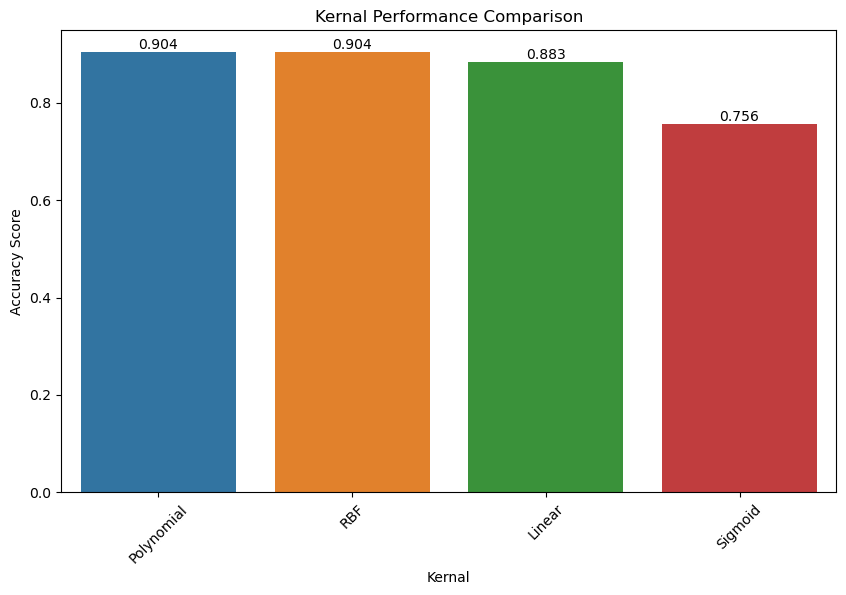

In [206]:
result_svm.sort_values(by='Score', ascending=False, inplace=True)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

sns.barplot(x='Kernal', y='Score', data=result_svm, ax=ax)
ax.bar_label(ax.containers[0], fmt='%.3f')
ax.set_xticklabels(labels=result_svm.Kernal, rotation=45)
plt.title('Kernal Performance Comparison')
plt.ylabel('Accuracy Score')
plt.show()

###

# Model Performance Comparisson

In [232]:
result = pd.DataFrame({
    'Algorithm': ['RandomForestClassifier', 'LogisticRegression','XGBoostClassifier','GradientBoostClassifier','AdaBoostClassifier','SVM'],
    'Score': [Accuracy_rf, Accuracy_logi,Accuracy_xgb,Accuracy_gbm,Accuracy_ada,Accuracy_svm_rbfK]
})
result

NameError: name 'Accuracy_rf' is not defined

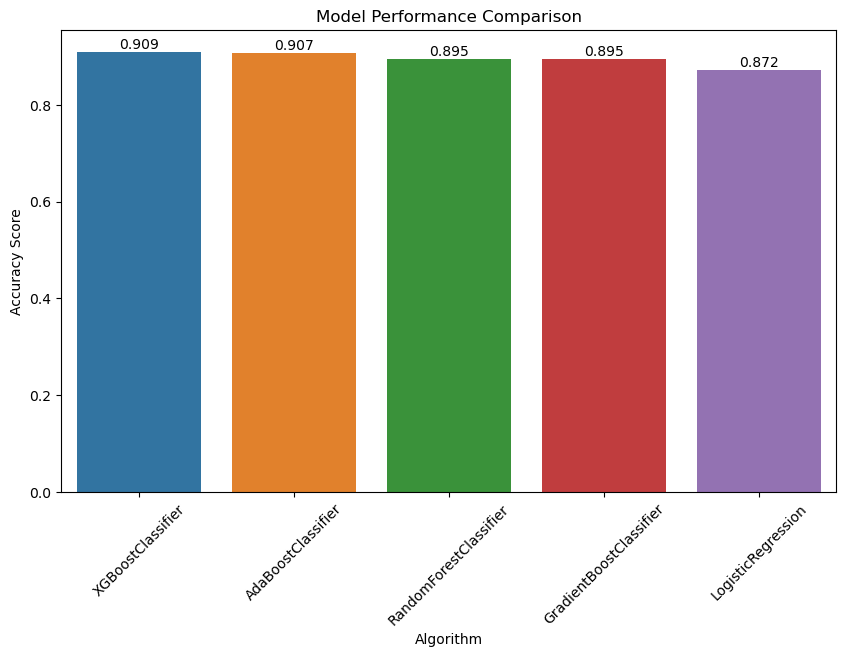

In [93]:
result.sort_values(by='Score', ascending=False, inplace=True)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

sns.barplot(x='Algorithm', y='Score', data=result, ax=ax)
ax.bar_label(ax.containers[0], fmt='%.3f')
ax.set_xticklabels(labels=result.Algorithm, rotation=45)
plt.title('Model Performance Comparison')
plt.ylabel('Accuracy Score')
plt.show()

## Variable Importance 

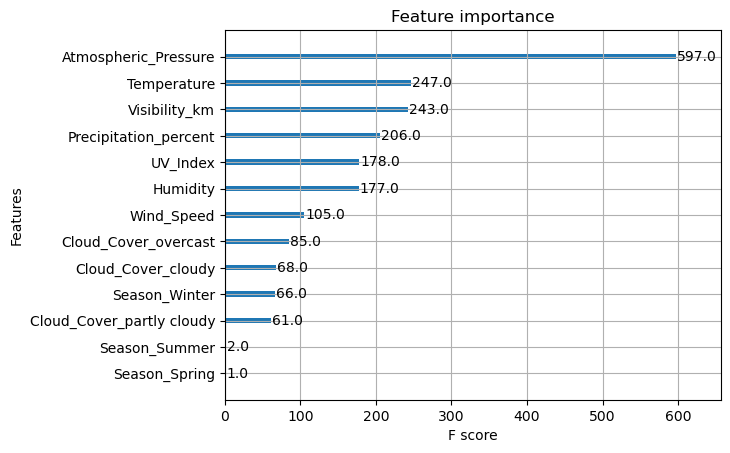

In [94]:
from xgboost import plot_importance
from matplotlib import pyplot

plot_importance(best_xgb_model)
pyplot.show()

In [ ]:
from sklearn.feature_selection import SelectFromModel
from numpy import sort

thresholds = sort(best_xgb_model.feature_importances_)

for thresh in thresholds:
    selection = SelectFromModel(best_xgb_model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train.values)
    selection_model = xgb.XGBClassifier()
    selection_model.fit(select_X_train, Y_train)
    
    select_X_test = selection.transform(X_test.values)  
    y_pred = selection_model.predict(select_X_test)
    
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(Y_test, predictions)
    
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy * 100.0))

In [99]:
feature_names = best_xgb_model.feature_names_in_
for idx, name in enumerate(feature_names):
    print(f"Index: {idx}, Feature Name: {name}")

Index: 0, Feature Name: Temperature
Index: 1, Feature Name: Humidity
Index: 2, Feature Name: Wind_Speed
Index: 3, Feature Name: Precipitation_percent
Index: 4, Feature Name: Atmospheric_Pressure
Index: 5, Feature Name: UV_Index
Index: 6, Feature Name: Visibility_km
Index: 7, Feature Name: Cloud_Cover_cloudy
Index: 8, Feature Name: Cloud_Cover_overcast
Index: 9, Feature Name: Cloud_Cover_partly cloudy
Index: 10, Feature Name: Season_Spring
Index: 11, Feature Name: Season_Summer
Index: 12, Feature Name: Season_Winter
Index: 13, Feature Name: Location_inland
Index: 14, Feature Name: Location_mountain


In [97]:
from sklearn.inspection import PartialDependenceDisplay
from matplotlib import pyplot as plt

In [101]:
selected_features = ['Temperature', 'Atmospheric_Pressure', 'Precipitation_percent','Visibility_km']
selected_indices = [list(feature_names).index(name) for name in selected_features]
print("Selected feature indices:", selected_indices)

Selected feature indices: [0, 4, 3, 6, 5]


In [104]:
target_classes = best_xgb_model.classes_
print("Target Classes:", target_classes)

Target Classes: [0 1 2 3]


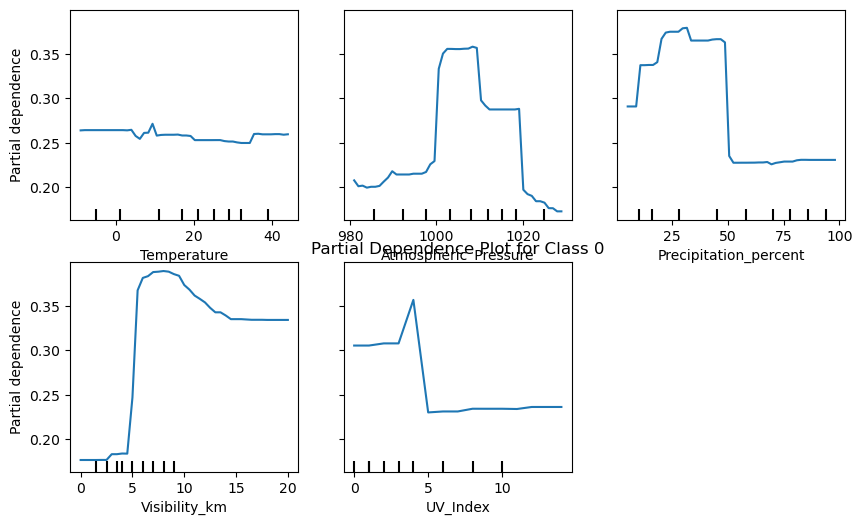

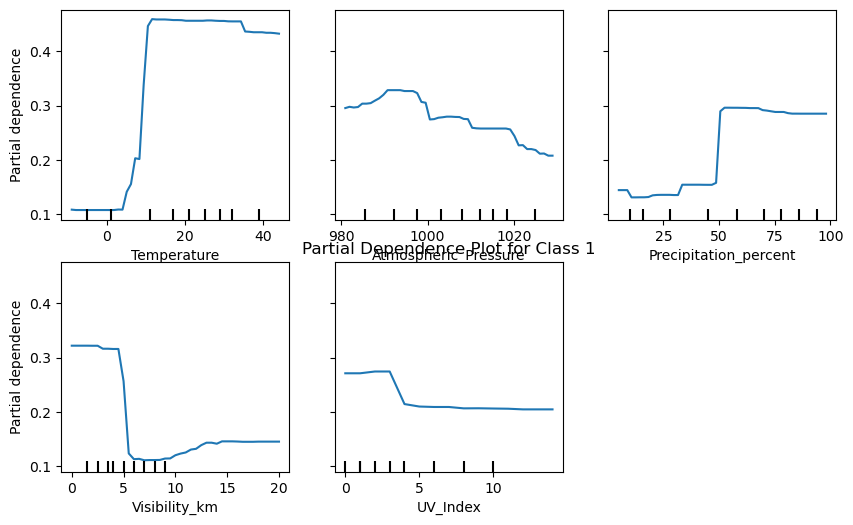

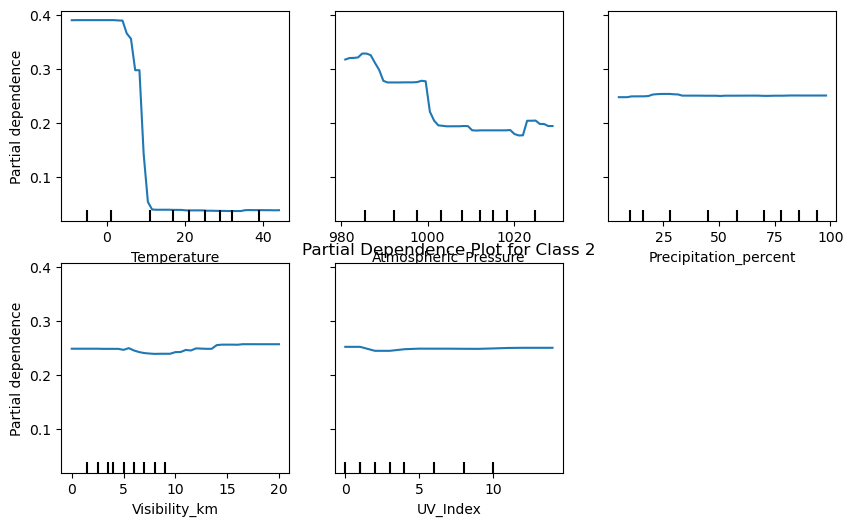

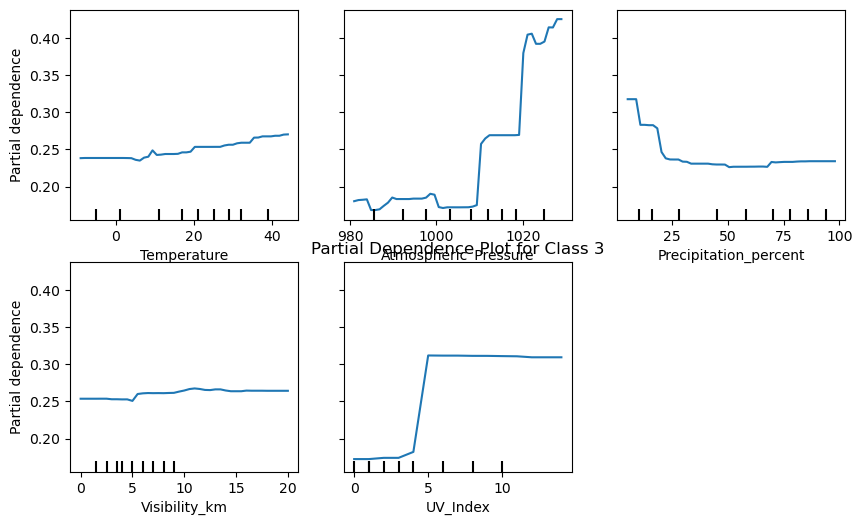

In [108]:
for target_class in target_classes:
    fig, ax = plt.subplots(figsize=(10, 6))
    PartialDependenceDisplay.from_estimator(
        estimator=best_xgb_model,
        X=X_train,
        features=selected_indices, 
        grid_resolution=50,
        target=target_class,
        ax=ax
    )
    
    plt.title(f"Partial Dependence Plot for Class {target_class}")
    plt.show()